<a href="https://colab.research.google.com/github/AJH0625/NLP-study/blob/main/6%EC%9E%A5_%EA%B2%8C%EC%9D%B4%ED%8A%B8%EA%B0%80_%EC%B6%94%EA%B0%80%EB%90%9C_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##6.1.4 기울기 폭발 대책

In [5]:
import numpy as np

dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
  total_norm = 0
  for grad in grads:
    total_norm += np.sum(grad**2)
  total_norm = np.squrt(total_norm)

  rate = max_norm / (total_norm + 1e-6)
  if rate<1:
    for grad in grads:
      grad *= rate

##6.3 LSTM 구현

In [6]:
class LSTM:
  def __init(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev, shape

    A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

    #slice
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:]

    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)

    c_next = f * c_prev + g*i
    h_next = o * np.tanh(c_next)

    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

##6.3.1 Time LSTM 구현

In [7]:
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None
    self.h, self.c = None, None
    self.dh = None
    self.stateful = stateful

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]

    self.layers=[]
    hs = np.empty((N,T,H), dtype='f')

    if not self.stateful or self.h is None:
      self.h = np.zeros((N,H), dtype='f')
    if not self.stateful or self.c is None:
      self.c = np.zeros((N,H), dtype='f')

    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h

      self.layers.append(layer)

    return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]

    dxs = np.empty((N,T,D), dtype='f')
    dh, dc = 0, 0

    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
      dxs[:, t, :] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad

      for i, grad in enumerate(grads):
        self.grads[i][...] = grad
        self.dh = dh
        return dxs

  def set_state(self, h, c=None):
    self.h, self.c = h, c

  def reset_state(self):
    self.h, self.c = None, None

##6.4 LSTM을 사용한 언어 모델

In [8]:
import sys
sys.path.append('..')
from common.time_layers import *
import pickle

class Rnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V,D) / 100).astype('f')
    lstm_Wx = (rn(D, 4*H) / np.sqrt((D)).astype('f'))
    lstm_Wh = (rn(H, 4*H) / np.sqrt((H)).astype('f'))
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(H,V) / np.sqrt((H)).astype('f'))
    affine_b = np.zeros(V).astype('f')

    self.layers = [
                   TimeEmbedding(embed_W),
                   TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
                   TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]

    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def predict(self, xs):
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs

  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.lstm_layer.reset_state()

  def save_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'wb') as f:
      pickle.dump(self.params, f)

  def load_params(self, file_name = 'Rnnlm.pkl'):
    with open(file_name, 'rb') as f:
      self.params = pickle.load(f)

Done
Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.00
| 에폭 1 |  반복 21 / 1327 | 시간 6[s] | 퍼플렉서티 2948.87
| 에폭 1 |  반복 41 / 1327 | 시간 13[s] | 퍼플렉서티 1202.02
| 에폭 1 |  반복 61 / 1327 | 시간 19[s] | 퍼플렉서티 976.98
| 에폭 1 |  반복 81 / 1327 | 시간 26[s] | 퍼플렉서티 783.35
| 에폭 1 |  반복 101 / 1327 | 시간 32[s] | 퍼플렉서티 676.78
| 에폭 1 |  반복 121 / 1327 | 시간 39[s] | 퍼플렉서티 637.98
| 에폭 1 |  반복 141 / 1327 | 시간 45[s] | 퍼플렉서티 602.33
| 에폭 1 |  반복 161 / 1327 | 시간 52[s] | 퍼플렉서티 577.47
| 에폭 1 |  반복 181 / 1327 | 시간 58[s] | 퍼플렉서티 606.94
| 에폭 1 |  반복 201 / 1327 | 시간 65[s] | 퍼플렉서티 513.68
| 에폭 1 |  반복 221 / 1327 | 시간 71[s] | 퍼플렉서티 494.64
| 에폭 1 |  반복 241 / 1327 | 시간 78[s] | 퍼플렉서티 444.05
| 에폭 1 |  반복 261 / 1327 | 시간 84[s] | 퍼플렉서티 470.32
| 에폭 1 |  반복 281 / 1327 | 시간 91[s] | 퍼플렉서티 455.64
| 에폭 1 |  반복 301 / 1327 | 시간 97[s] | 퍼플렉서티 396.49
| 에폭 1 |  반복 321 / 1327 | 시간 104[s] | 퍼플렉서티 343.00
| 에폭 1 |  반복 341 / 1327 | 시간 110[s] | 퍼플렉서티 405.31
| 에폭 1 |  반복 361 / 1327 | 시간 117[s] | 퍼플렉서티 406.69
| 에폭 1 |  반복 381 / 1327 | 시간 123[s] | 퍼플렉

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_

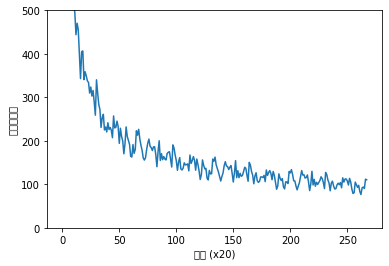

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  134.9124791989024


In [9]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm

batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

model.save_params()

##6.5.4 개선된 RNNLM 구현

In [2]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
  def __init__(self, vocab_size=10000, wordvec_size=650,
               hidden_size=650, dropout_ratio=0.5):
    V,D,H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V,D)/100).astype('f')
    lstm_Wx1 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
    lstm_Wh1 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b1 = np.zeros(4*H).astype('f')
    lstm_Wx2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_Wh2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b2 = np.zeros(4*H).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.layers = [
                   TimeEmbedding(embed_W),
                   TimeDropout(dropout_ratio),
                   TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
                   TimeDropout(dropout_ratio),
                   TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
                   TimeDropout(dropout_ratio),
                   TimeAffine(embed_W.T, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layers = [self.layers[2], self.layers[4]]
    self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
    self.params, self.grads = [], []
    
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def predict(self, xs, train_flg = False):
    for layer in self.drop_layers:
      layer.train_flg = train_flg
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs

  def forward(self, xs, ts, train_flg=True):
    score = self.predict(xs, train_flg)
    loss = self.loss_layer.forward(score, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    for layer in self.lstm_layers:
      layer.reset_state()

In [3]:
import sys
sys.path.append('..')
from common import config
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
config.GPU = True

batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 1
max_grad = 0.25
dropout = 0.5

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
  trainer.fit(xs, ts, max_epoch=1, batch_size = batch_size,
              time_size=time_size, max_grad=max_grad)
  model.reset_state()
  ppl = eval_perplexity(model, corpus_val)
  print('검증 퍼플렉서티: ',ppl)

  if best_ppl > ppl:
    best_ppl = ppl
    model.save_params()

  else:
    lr /= 4.0
    optimizer.lr = lr

  model.reset_state()
  print('-'*50)

Done
Done
Done
| 에폭 1 |  반복 1 / 1327 | 시간 3[s] | 퍼플렉서티 9999.62
| 에폭 1 |  반복 21 / 1327 | 시간 62[s] | 퍼플렉서티 3668.82
| 에폭 1 |  반복 41 / 1327 | 시간 122[s] | 퍼플렉서티 1860.70
| 에폭 1 |  반복 61 / 1327 | 시간 181[s] | 퍼플렉서티 1327.48
| 에폭 1 |  반복 81 / 1327 | 시간 239[s] | 퍼플렉서티 1113.42
| 에폭 1 |  반복 101 / 1327 | 시간 297[s] | 퍼플렉서티 830.34
| 에폭 1 |  반복 121 / 1327 | 시간 355[s] | 퍼플렉서티 831.63
| 에폭 1 |  반복 141 / 1327 | 시간 413[s] | 퍼플렉서티 746.42
| 에폭 1 |  반복 161 / 1327 | 시간 470[s] | 퍼플렉서티 693.78
| 에폭 1 |  반복 181 / 1327 | 시간 528[s] | 퍼플렉서티 685.71
| 에폭 1 |  반복 201 / 1327 | 시간 586[s] | 퍼플렉서티 599.10
| 에폭 1 |  반복 221 / 1327 | 시간 642[s] | 퍼플렉서티 582.94
| 에폭 1 |  반복 241 / 1327 | 시간 697[s] | 퍼플렉서티 529.97
| 에폭 1 |  반복 261 / 1327 | 시간 752[s] | 퍼플렉서티 547.81
| 에폭 1 |  반복 281 / 1327 | 시간 809[s] | 퍼플렉서티 526.42
| 에폭 1 |  반복 301 / 1327 | 시간 865[s] | 퍼플렉서티 458.53
| 에폭 1 |  반복 321 / 1327 | 시간 920[s] | 퍼플렉서티 404.16
| 에폭 1 |  반복 341 / 1327 | 시간 975[s] | 퍼플렉서티 454.34
| 에폭 1 |  반복 361 / 1327 | 시간 1031[s] | 퍼플렉서티 477.62
| 에폭 1 |  반복 381 / 

##RNNLM 개선!!

1. LSTM 계층 다층화
  - 첫 번째 LSTM 계층의 은닉 상태가 두 번째 LSTM 계층에 입력됨 → 더 복잡한 패턴 학습 가능
2. 드롭아웃에 의한 오버피팅 억제
  - 드롭아웃으로 훈련 시 계층 내의 뉴런 n개를 무작위로 무시하고 학습(정규화)
  - 변형 드롭아웃: 같은 계층에 적용되는 드롭아웃끼리는 공통의 마스크를 이용함으로 시간 방향 드롭아웃도 효과적으로 작동 가능
3. 가중치 공유 
  - Embedding 계층과 Softmax 앞단의 Affine 계층이 가중치를 공유함 → 학습하는 매개변수 수가 크게 줄어드는 동시에 정확도도 향상됨